## Exploratory Data Analysis

The first step in EDA for building a predictive model for F1 race results and after importing the necessary packages is to investigate the data types of the features in the main dataframe and turn any important non-numerical features into integers or floats.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('../csv/cleaned_data.csv')
df

resultId  raceId  driverId  constructorId  grid position  \
0             1      18         1              1     1        1   
1             2      18         2              2     5        2   
2             3      18         3              3     7        3   
3             4      18         4              4    11        4   
4             5      18         5              1     3        5   
...         ...     ...       ...            ...   ...      ...   
25395     25401    1073       849              3    16       \N   
25396     25402    1073       841             51    14       \N   
25397     25403    1073       847              3    17       \N   
25398     25404    1073         8             51    18       \N   
25399     25405    1073       853            210    20       \N   

       positionOrder  points  laps         time  ... rank fastestLapTime  \
0                  1    10.0    58  1:34:50.616  ...    2       1:27.452   
1                  2     8.0    58       +5.478  ...    3       1:27.739   
2                  3     6.0    58       +8.163  ...    5       1:28.090   
3                  4     5.0    58      +17.181  ...    7       1:28.603   
4                  5     4.0    58      +18.014  ...    1       1:27.418   
...              ...     ...   ...          ...  ...  ...            ...   
25395             16     0.0    50           \N  ...   15       1:29.293   
25396             17     0.0    33           \N  ...   16       1:29.442   
25397             18     0.0    26           \N  ...   19       1:30.647   
25398             19     0.0    25           \N  ...   18       1:29.698   
25399             20     0.0     0           \N  ...    0             \N   

      fastestLapSpeed statusId   driverRef         dob constructorRef  \
0             218.300        1    hamilton  1985-01-07        mclaren   
1             217.586        1    heidfeld  1977-05-10     bmw_sauber   
2             216.719        1     rosberg  1985-06-27       williams   
3             215.464        1      alonso  1981-07-29        renault   
4             218.385        1  kovalainen  1981-10-19        mclaren   
...               ...      ...         ...         ...            ...   
25395         212.912        3      latifi  1995-06-29       williams   
25396         212.557        6  giovinazzi  1993-12-14           alfa   
25397         209.732        6     russell  1998-02-15       williams   
25398         211.951       23   raikkonen  1979-10-17           alfa   
25399              \N      139     mazepin  1999-03-02           haas   

         status constructorPoints         avgPit  
0      Finished              14.0   74893.543981  
1      Finished               8.0   22933.320000  
2      Finished               9.0   49760.690763  
3      Finished               5.0   69458.586705  
4      Finished              14.0   24608.666667  
...         ...               ...            ...  
25395  Accident              23.0  172965.666667  
25396   Gearbox              13.0  133525.953704  
25397   Gearbox              23.0  135214.130841  
25398    Brakes              13.0   77797.626404  
25399   Illness               0.0  211286.047619  

[25400 rows x 22 columns]

### Changing Data Types

In [3]:
df.dtypes

resultId               int64
raceId                 int64
driverId               int64
constructorId          int64
grid                   int64
position              object
positionOrder          int64
points               float64
laps                   int64
time                  object
milliseconds          object
fastestLap            object
rank                  object
fastestLapTime        object
fastestLapSpeed       object
statusId               int64
driverRef             object
dob                   object
constructorRef        object
status                object
constructorPoints    float64
avgPit               float64
dtype: object

'position' is an object and has some NaN values corresponding to DNF results since a DNF doesn't confer a finishing order; no DNF driver finishes in front of or behind another. But helpfully, 'positionOrder' looks like it accomplishes the same thing and is numerical. It also assigns DNFers a rank order.

'milliseconds' (the duration of a driver's race), 'rank' (a driver's fastest lap expressed as an ordinal number compared to all others,  fastestLapTime, and many other important columns are non-numerical and should be coerced.

In [4]:
df = df.drop(columns=['position', 'fastestLap'])

In [5]:
df['milliseconds'] = pd.to_numeric(df['milliseconds'], errors='coerce')
df['rank'] = pd.to_numeric(df['rank'], errors='coerce')
df['fastestLapSpeed'] = pd.to_numeric(df['fastestLapSpeed'], errors='coerce')

df.dtypes

resultId               int64
raceId                 int64
driverId               int64
constructorId          int64
grid                   int64
positionOrder          int64
points               float64
laps                   int64
time                  object
milliseconds         float64
rank                 float64
fastestLapTime        object
fastestLapSpeed      float64
statusId               int64
driverRef             object
dob                   object
constructorRef        object
status                object
constructorPoints    float64
avgPit               float64
dtype: object

Now the features are numerical data types - but many values in some of these columns, such as 'milliseconds', are NaN because they also represent DNFs. What to do with these values is tricky; the rows shouldn't be discarded, because they contain other important data that could be instructive for our model, and because a DNF finish itself is important for predicting future performance. A note for a future feature engineering step may be to calculate a 'rate of DNF' column which I would expect to correlate negatively with my ultimate target category, positionOrder.

### Creating the Split

There's another category, 'time', which is currently non-numeric but I haven't yet adjusted because it needs some additional work. 'time' is a measure of a driver's total duration on the track, assuming they finished. DNFers get the now-familiar \N string value. However, only the driver in first position gets an actual time stamp as the value; the rest get a measure of time that they spent on the track _longer_ than the winner. So, if Valteri Bottas finished five seconds slower than Lando Norris who won, Norris would get a value like "1:36:02:57" while Bottas' would be "+5.000".

In order to make this category more useful as performance data for my future model, I'd like to turn the winner's time into a zero and retain the other finisher's time. In this way, the column will negatively correlate with finishing position. The lower your value in this column, the closer you were to winning the race. This is essentially a statistic familiar to F1 fans known as a "split" to the leader which is frequently shown throughout a Grand Prix as an on-screen graphic. With split, a positive time represents a slower car.

In [6]:
df.loc[df['positionOrder'] == 1, 'time'] = 0

In [7]:
df['time']

0              0
1         +5.478
2         +8.163
3        +17.181
4        +18.014
          ...   
25395         \N
25396         \N
25397         \N
25398         \N
25399         \N
Name: time, Length: 25400, dtype: object

Looks good! We now have a nice split, just not in a type we can work with. Now it's just a matter of coercing the string values to numbers and NaNs.

In [8]:
df['time'] = pd.to_numeric(df['time'], errors='coerce')

df['time']

0         0.000
1         5.478
2         8.163
3        17.181
4        18.014
          ...  
25395       NaN
25396       NaN
25397       NaN
25398       NaN
25399       NaN
Name: time, Length: 25400, dtype: float64

### Turning Times into Milliseconds

Finally, there is another column with timecode-esque string values that would be better converted to milliseconds: fastestLapTime.

In [9]:
df['fastestLapTime'] = pd.to_datetime(df['fastestLapTime'], errors='coerce')

In [10]:
(df['fastestLapTime'].dt.hour*60+df['fastestLapTime'].dt.minute)*60 + df['fastestLapTime'].dt.second*1000

0        32220.0
1        49220.0
2        10280.0
3        41280.0
4        30220.0
          ...   
25395    22340.0
25396    31340.0
25397    43400.0
25398    46340.0
25399        NaN
Name: fastestLapTime, Length: 25400, dtype: float64

Before moving on, there's one feature I want to include from the Ergast database: track. Different races take place on different tracks, and different tracks have different characteristics that can make them better or worse for specific drivers.

The best way to include this data is to first merge the circuitId from the races table, since the results table and circuits table don't share a foreign key but results and races do. Then I can merge circuits and results on the circuitId to get the circuit names as categorical variables.

Again, it's better to get the circuit names (i.e. "Circuit of the Americas") than the race names ("US Grand Prix") because races have been held at multiple circuits over the years.

In [12]:
df_circuits = pd.read_csv('../csv/circuits.csv')
df_races = pd.read_csv('../csv/races.csv')

df = df.merge(df_races[['raceId', 'circuitId']], on = 'raceId', how = 'left')
df = df.merge(df_circuits[['circuitId', 'circuitRef']])

In [13]:
df.drop(['circuitId', 'circuitId_x', 'circuitId_y'], axis=1, inplace=True)
df

resultId  raceId  driverId  constructorId  grid  positionOrder  points  \
0             1      18         1              1     1              1    10.0   
1             2      18         2              2     5              2     8.0   
2             3      18         3              3     7              3     6.0   
3             4      18         4              4    11              4     5.0   
4             5      18         5              1     3              5     4.0   
...         ...     ...       ...            ...   ...            ...     ...   
25395     25381    1072        20            117    17             16     0.0   
25396     25382    1072       815              9     5             17     0.0   
25397     25383    1072       853            210    20             18     0.0   
25398     25384    1072       847              3    14             19     0.0   
25399     25385    1072       854            210    19             20     0.0   

       laps    time  milliseconds  ...      fastestLapTime fastestLapSpeed  \
0        58   0.000     5690616.0  ... 2022-07-29 01:27:27         218.300   
1        58   5.478     5696094.0  ... 2022-07-29 01:27:44         217.586   
2        58   8.163     5698779.0  ... 2022-07-29 01:28:05         216.719   
3        58  17.181     5707797.0  ... 2022-07-29 01:28:36         215.464   
4        58  18.014     5708630.0  ... 2022-07-29 01:27:25         218.385   
...     ...     ...           ...  ...                 ...             ...   
25395    44     NaN           NaN  ... 2022-07-29 01:34:01         236.375   
25396    14     NaN           NaN  ... 2022-07-29 01:34:08         236.104   
25397    14     NaN           NaN  ... 2022-07-29 01:37:02         229.036   
25398    14     NaN           NaN  ... 2022-07-29 01:36:07         231.211   
25399     8     NaN           NaN  ... 2022-07-29 01:36:02         231.421   

       statusId        driverRef         dob constructorRef            status  \
0             1         hamilton  1985-01-07        mclaren          Finished   
1             1         heidfeld  1977-05-10     bmw_sauber          Finished   
2             1          rosberg  1985-06-27       williams          Finished   
3             1           alonso  1981-07-29        renault          Finished   
4             1       kovalainen  1981-10-19        mclaren          Finished   
...         ...              ...         ...            ...               ...   
25395       130           vettel  1987-07-03   aston_martin  Collision damage   
25396         4            perez  1990-01-26       red_bull         Collision   
25397         4          mazepin  1999-03-02           haas         Collision   
25398         4          russell  1998-02-15       williams         Collision   
25399         3  mick_schumacher  1999-03-22           haas          Accident   

      constructorPoints         avgPit   circuitRef  
0                  14.0   74893.543981  albert_park  
1                   8.0   22933.320000  albert_park  
2                   9.0   49760.690763  albert_park  
3                   5.0   69458.586705  albert_park  
4                  14.0   24608.666667  albert_park  
...                 ...            ...          ...  
25395              77.0   71738.981395       jeddah  
25396             559.5   74356.862155       jeddah  
25397               0.0  211286.047619       jeddah  
25398              23.0  135214.130841       jeddah  
25399               0.0  201851.200000       jeddah  

[25400 rows x 21 columns]

### Who Wins Most? Who Crashes More?

I start with some basic graphical analysis using the features available. For starters, I plot race wins for each of the drivers in the dataset.

In [14]:
winning_drivers = df.loc[df['positionOrder'] == 1, 'driverRef']

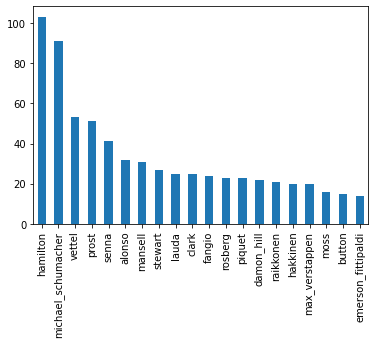

In [15]:
_ = winning_drivers.value_counts().head(20).plot(kind='bar')

This is a helpful look at winningest drivers, but there are some legendary drivers here like Alain Prost and Ayrton Senna who are no longer active. In modeling, I'll probably want to find a way to mask out inactive drivers. I may do this by creating a boolean mask for a list of active drivers, or by using the 'dob' field to filter out drivers older than F1's reigning iron man, the 41 year old Fernando Alonso.

Winning teams is a different proposition, where we'd like to take into account the team's entire historical performance since it's entirely plausible that experience gained since a team's inception still plays a role in its contemporary performance. I'll still want to limit my model to active teams, but there's no age limit to a team.

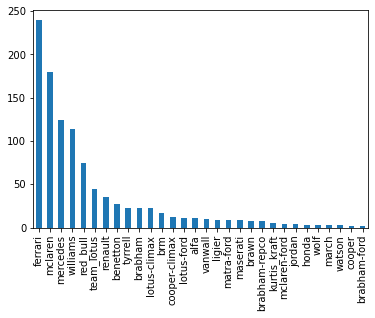

In [16]:
winning_teams = df.loc[df['positionOrder'] == 1, 'constructorRef']
_ = winning_teams.value_counts().head(30).plot(kind='bar')

As an aside, but a possibly useful one, we can see from the 'status' column that there are many reasons for drivers to fail to finish a race. What are the most common ones?

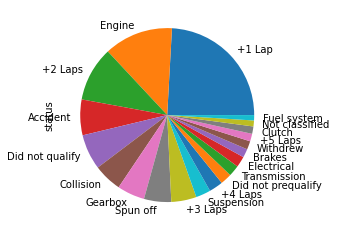

In [17]:
DNF_causes = df.loc[df['status'] != 'Finished', 'status']
_ = DNF_causes.value_counts().head(20).plot(kind='pie')

### Correlations

The most helpful analysis at this stage is a look at how different features correlate to our target feature, positionOrder.

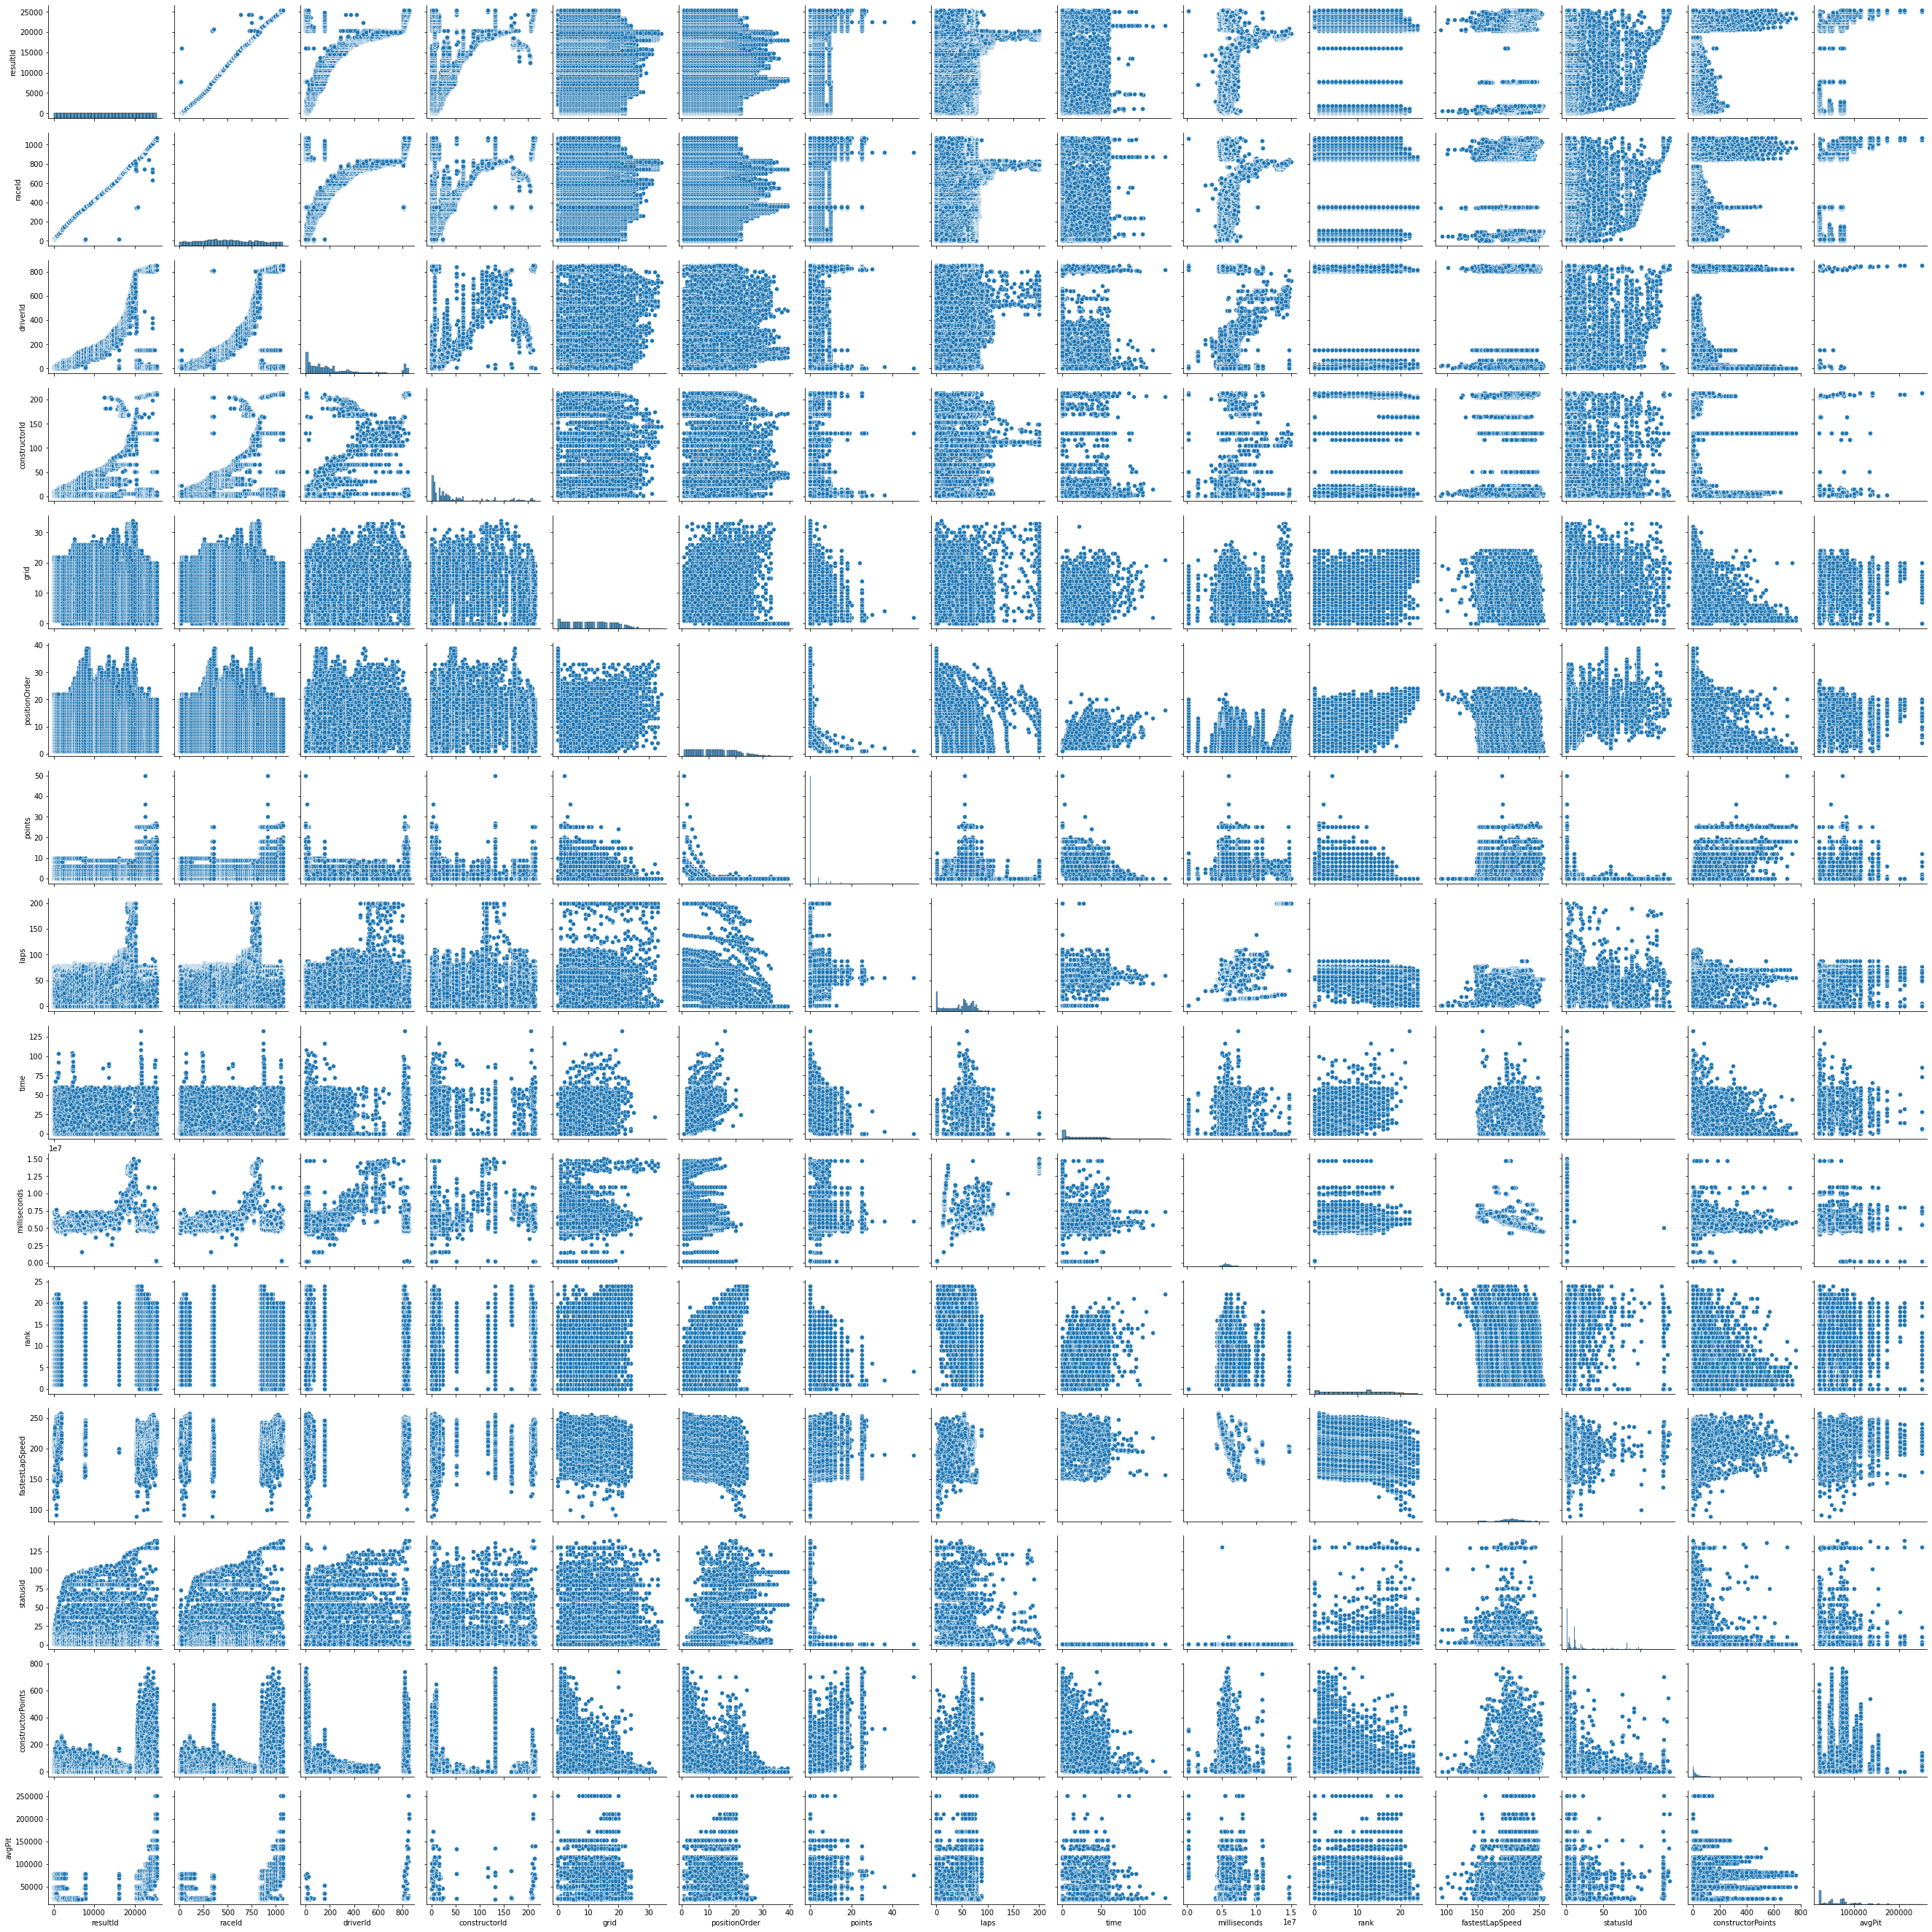

In [18]:
_ = sns.pairplot(df)

At a quick glance, it looks like there may be some correlation patterns in scatterplots between positionOrder and grid, time, and rank. There may be negative correlations between positionOrder and points, constructorPoints, and laps.

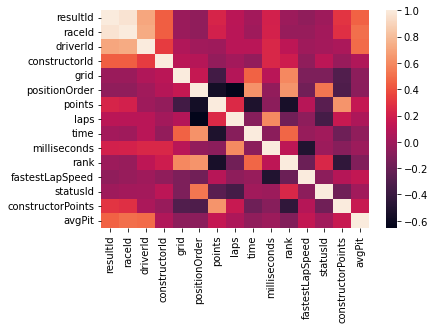

In [19]:
_ = sns.heatmap(df.corr())

Based on correlation coefficients, there appear to be some promising features vis-a-vis positionOrder. Points and laps are strongly correlated.

In [21]:
df.to_csv('../csv/for_preprocessing.csv')